# Histogram

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, gamma, expon, poisson, t
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest, binom_test

# Data: 89 out of 100 trains on time
successes = 89
n_obs = 100
p_null = 0.95

# Exact binomial test (two-sided)
pval_exact = binom_test(successes, n_obs, p_null, alternative='two-sided')

# Manual Yates continuity correction (like R's prop.test)
phat = successes / n_obs
se = np.sqrt(p_null * (1 - p_null) / n_obs)
correction = 0.5 / n_obs
z_corrected = (abs(phat - p_null) - correction) / se
p_corrected = 2 * (1 - norm.cdf(z_corrected))  # two-sided p-value

# Output
{   
    "Exact binomial test p-value": pval_exact,
    "Z-statistic (with Yates correction)": z_corrected,
    "p-value (approximate, R-style)": p_corrected
}


{'Exact binomial test p-value': 0.01739293928781874,
 'Z-statistic (with Yates correction)': 2.523573072576176,
 'p-value (approximate, R-style)': 0.01161689143415856}

In [2]:
n_obs = 1000
# Exact binomial test (two-sided)
pval_exact = binom_test(successes, n_obs, p_null, alternative='two-sided')

# Manual Yates continuity correction (like R's prop.test)
phat = successes / n_obs
se = np.sqrt(p_null * (1 - p_null) / n_obs)
correction = 0.5 / n_obs
z_corrected = (abs(phat - p_null) - correction) / se
p_corrected = 2 * (1 - norm.cdf(z_corrected))  # two-sided p-value

# Output
{ "Exact binomial test p-value": pval_exact,
    "Z-statistic (with Yates correction)": z_corrected,
    "p-value (approximate, R-style)": p_corrected
}


{'Exact binomial test p-value': 0.0,
 'Z-statistic (with Yates correction)': 124.85446264393295,
 'p-value (approximate, R-style)': 0.0}

# Shapiro-Wilk test for normality

In [6]:
from scipy.stats import shapiro
# Load Amsterdam data
amsterdam = np.loadtxt("amsterdam.txt").flatten()
# Perform Shapiro-Wilk test
shapiro_stat, shapiro_p = shapiro(amsterdam)

# Output result
{
    "Shapiro-Wilk statistic": shapiro_stat,
    "p-value": shapiro_p,
    "Conclusion (alpha=0.05)": "Reject H0 (not normal)" if shapiro_p < 0.05 else "Fail to reject H0 (normal)"
}

{'Shapiro-Wilk statistic': 0.9884761389099086,
 'p-value': 0.5439494488644457,
 'Conclusion (alpha=0.05)': 'Fail to reject H0 (normal)'}

# Collection of Normality Tests

In [9]:
from scipy.stats import (kstest, shapiro, normaltest, jarque_bera, cramervonmises, anderson, chisquare)
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import (norm, uniform, triang, expon, arcsine, gamma)
from collections import namedtuple
from tabulate import tabulate
import numpy as np

def normality_tests(samples, number_of_bins = 15):
    ''' normality tests using all available python libraries
        number_of_bins: effective only for chi-square test,
        1.Kolmogorov-Smirnov test,
        2.Shapiro-Wilk test,
        3.D'Agostino's K-squared test,
        4.Jarque–Bera test,
        5.Lilliefors test,
        6.Cramér–von Mises criterion,
        7.Chisquare test,
        8.Anderson-Darling test
        '''
    
    # Lilliefors renamed using named tuple to hamornize its name with others
    LillieforsResult = namedtuple('LillieforsResult', ['statistic', 'pvalue'])
    lil = lilliefors(samples)
    
    # for chi-square test
    f_obs, bins =  np.histogram(samples, bins=number_of_bins)
    tempo = [norm.cdf(bins[i+1]) - norm.cdf(bins[i])
             for i in range(len(bins)-1)]
    f_exp = np.array(tempo)*len(samples)/np.sum(tempo)       # normalized
    ChisquareResult = namedtuple('ChisquareResult',['statistic', 'pvalue'])
    chi = chisquare(f_obs=f_obs, f_exp=f_exp)
    
    return [kstest(samples, 'norm'),          
            shapiro(samples),                 
            normaltest(samples),   
            jarque_bera(samples), 
            LillieforsResult(lil[0], lil[1]), 
            cramervonmises(samples, 'norm'),
            ChisquareResult(chi[0], chi[1]),
            anderson(samples)]
    
def pass_fail(test):
    '''make decisions whether pass or fail with a significance level of 5 %'''

    result = ['pass' if test[i].pvalue > 0.05 else 'fail' for i in range(7)]
    result.append('pass' if test[7].critical_values[2]>test[7].statistic 
                  else 'fail')
    return result

def print_out(out, result):
    '''print out the test result using tubulate library
       out: from normality_tests function
       result: from pass_fail function'''
    
    # method names from function.__doc__
    method = [normality_tests.__doc__.translate(
             str.maketrans('', '', '\n')).split(",")[i].
             strip() for i in range(1,9)]
    array =[]
    for i in range(len(out)-1):                      # from method 1 to 7
        sub_array = [method[i], f'{out[i].statistic:.4f}', 
                     f'{out[i].pvalue:.4f}', result[i]]
        array.append(sub_array)  
    # a significance level of 5 % for method 8    
    array.append([method[-1], f'{out[-1].statistic:.4f}', 
                  f'{out[-1].critical_values[2]:.4f}*', result[-1]])
    print(tabulate(array, headers=["test methods", "statistic", 
                                "p-value*", "result"]))
    print('*Not a p-value but a critical-value for a signif.level of 5%')

In [11]:
out = normality_tests(amsterdam)
result = pass_fail(out)

print_out(out, result)

test methods                     statistic  p-value*    result
-----------------------------  -----------  ----------  --------
1.Kolmogorov-Smirnov test           1       0.0000      fail
2.Shapiro-Wilk test                 0.9885  0.5439      pass
3.D'Agostino's K-squared test       1.013   0.6026      pass
4.Jarque–Bera test                  1.0506  0.5914      pass
5.Lilliefors test                   0.0913  0.0413      fail
6.Cramér–von Mises criterion       33.3333  0.0000      fail
7.Chisquare test                  nan       nan         fail
8.Anderson-Darling test             0.3913  0.7590*     pass
*Not a p-value but a critical-value for a signif.level of 5%


# Example – incomes of Amsterdam and Rotterdam

Shapiro test on normal sample: ShapiroResult(statistic=0.9857241339772836, pvalue=0.3576761873444013)


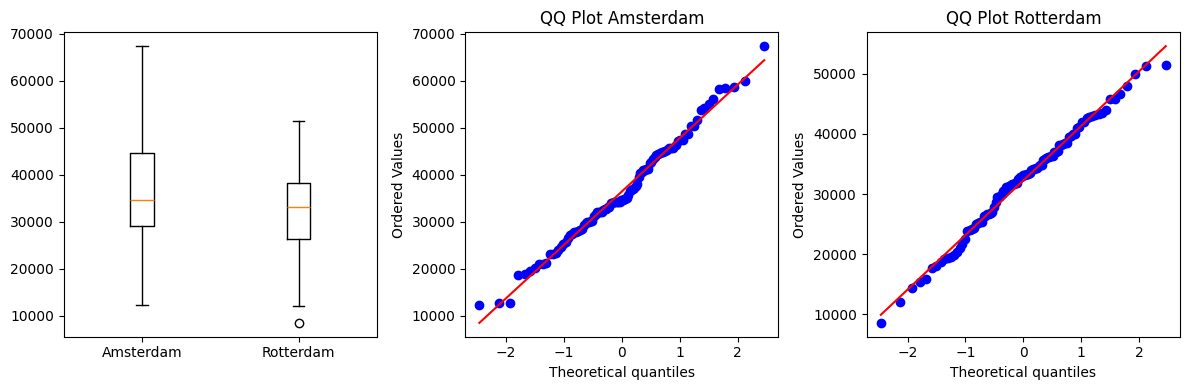

Amsterdam mean, sd, n: 36402.279 11244.346762522648 100
Rotterdam mean, sd, n: 32257.9579 8984.440159807858 100
Shapiro test Amsterdam: ShapiroResult(statistic=0.9884761389099086, pvalue=0.5439494488644457)
Shapiro test Rotterdam: ShapiroResult(statistic=0.99040095310556, pvalue=0.6970062617516154)
T-test (Welch): TtestResult(statistic=2.879420973742729, pvalue=0.004422232057504286, df=198.0)
T-test (equal var): TtestResult(statistic=2.879420973742729, pvalue=0.004422232057504286, df=198.0)


In [14]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
# === Load Datasets ===
amsterdam = np.loadtxt('amsterdam.txt').flatten()
rotterdam = np.loadtxt('rotterdam.txt').flatten()
income = pd.read_csv('income.txt', sep=r"\s+")
parcels = pd.read_csv('parcels.txt', sep=r"\s+")
taxcouple = pd.read_csv("taxcouple.txt", sep=r"\s+")
# === Normality Test Example ===
x = np.random.normal(size=100)
print("Shapiro test on normal sample:", stats.shapiro(x))

# === Amsterdam vs Rotterdam Incomes ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.boxplot([amsterdam, rotterdam], labels=['Amsterdam', 'Rotterdam'])
plt.subplot(1, 3, 2)
stats.probplot(amsterdam, dist="norm", plot=plt)
plt.title("QQ Plot Amsterdam")
plt.subplot(1, 3, 3)
stats.probplot(rotterdam, dist="norm", plot=plt)
plt.title("QQ Plot Rotterdam")
plt.tight_layout()
plt.show()

print("Amsterdam mean, sd, n:", np.mean(amsterdam), np.std(amsterdam, ddof=1), len(amsterdam))
print("Rotterdam mean, sd, n:", np.mean(rotterdam), np.std(rotterdam, ddof=1), len(rotterdam))
print("Shapiro test Amsterdam:", stats.shapiro(amsterdam))
print("Shapiro test Rotterdam:", stats.shapiro(rotterdam))
print("T-test (Welch):", stats.ttest_ind(amsterdam, rotterdam))
print("T-test (equal var):", stats.ttest_ind(amsterdam, rotterdam, equal_var=True))


# Example – incomes of Amsterdam and Rotterdam

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro

# Load and clean the data
df = pd.read_csv("amsrotdam.txt", delim_whitespace=True)
df["city"] = df["city"].str.replace('"', '')
df["income"] = df["income"].astype(float)

# Split by city
amsterdam = df[df["city"] == 'a']["income"].to_numpy()
rotterdam = df[df["city"] == 'r']["income"].to_numpy()

# Function to summarize each city's data
def summarize_city(data):
    mean = np.mean(data)
    sd = np.std(data, ddof=1)
    n = len(data)
    w_stat, p_value = shapiro(data)
    return {
        "Mean": round(mean, 2),
        "SD": round(sd, 2),
        "N": n,
        "Shapiro-Wilk W": round(w_stat, 4),
        "p-value": round(p_value, 4)
    }

# Apply to both cities
results = {
    "Amsterdam": summarize_city(amsterdam),
    "Rotterdam": summarize_city(rotterdam)
}

# Display results
for city, stats in results.items():
    print(f"\n{city}")
    for key, value in stats.items():
        print(f"{key}: {value}")



Amsterdam
Mean: 36402.28
SD: 11244.35
N: 100
Shapiro-Wilk W: 0.9885
p-value: 0.5439

Rotterdam
Mean: 32257.96
SD: 8984.44
N: 100
Shapiro-Wilk W: 0.9904
p-value: 0.697


In [19]:
from scipy.stats import ttest_ind
# Welch's t-test (unequal variances)
t_stat, p_val = ttest_ind(amsterdam, rotterdam, equal_var=False)

# Confidence interval calculation (Welch)
from scipy.stats import t
n1, n2 = len(amsterdam), len(rotterdam)
mean1, mean2 = np.mean(amsterdam), np.mean(rotterdam)
var1, var2 = np.var(amsterdam, ddof=1), np.var(rotterdam, ddof=1)
se_diff = np.sqrt(var1/n1 + var2/n2)
df_welch = (var1/n1 + var2/n2)**2 / ((var1**2)/((n1**2)*(n1-1)) + (var2**2)/((n2**2)*(n2-1)))
ci_low = (mean1 - mean2) - t.ppf(0.975, df_welch) * se_diff
ci_high = (mean1 - mean2) + t.ppf(0.975, df_welch) * se_diff

# Output
{
    "t-statistic": round(t_stat, 4),
    "degrees of freedom": round(df_welch, 3),
    "p-value": round(p_val, 6),
    "95% Confidence Interval": (round(ci_low, 3), round(ci_high, 3)),
    "mean Amsterdam": round(mean1, 2),
    "mean Rotterdam": round(mean2, 2)
}

{'t-statistic': 2.8794,
 'degrees of freedom': 188.805,
 'p-value': 0.004444,
 '95% Confidence Interval': (1305.166, 6983.476),
 'mean Amsterdam': 36402.28,
 'mean Rotterdam': 32257.96}

In [21]:
from scipy.stats import ttest_ind

# Perform two-sample t-test assuming equal variances
t_stat_eq, p_val_eq = ttest_ind(amsterdam, rotterdam, equal_var=True)

# Output
{
    "t-statistic (equal variances)": round(t_stat_eq, 4),
    "p-value (equal variances)": round(p_val_eq, 6)
}

{'t-statistic (equal variances)': 2.8794,
 'p-value (equal variances)': 0.004422}

# Example – incomes of tax couples

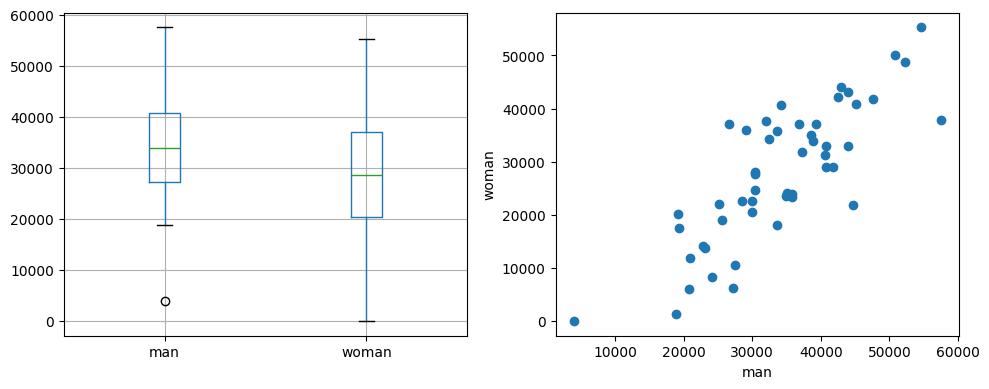

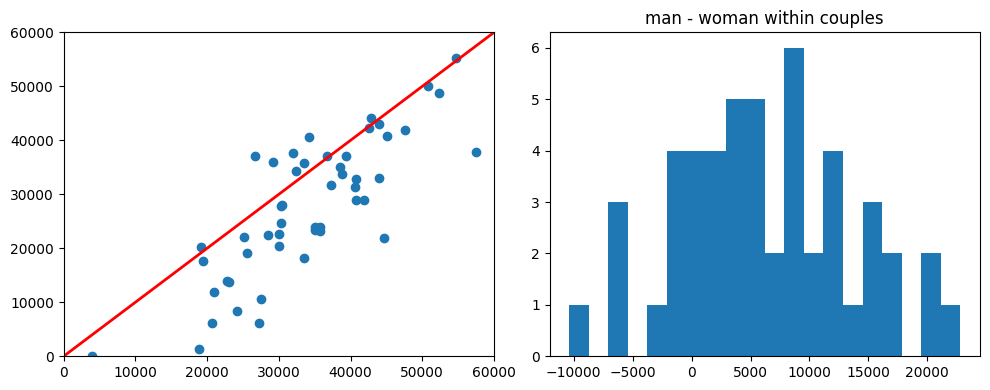

In [32]:
from scipy.stats import ttest_rel, t, probplot
from scipy.stats import ttest_1samp
# === Tax Couples Analysis ===
man = taxcouple["man"]
woman = taxcouple["woman"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
taxcouple.boxplot()
plt.subplot(1, 2, 2)
plt.scatter(man, woman)
plt.xlabel("man")
plt.ylabel("woman")
plt.tight_layout()
plt.show()

d = man - woman
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(man, woman)
plt.plot([0, 60000], [0, 60000], color='red', linewidth=2)
plt.xlim([0, 60000])
plt.ylim([0, 60000])
plt.subplot(1, 2, 2)
plt.hist(d, bins=20)
plt.title("man - woman within couples")
plt.tight_layout()
plt.show()



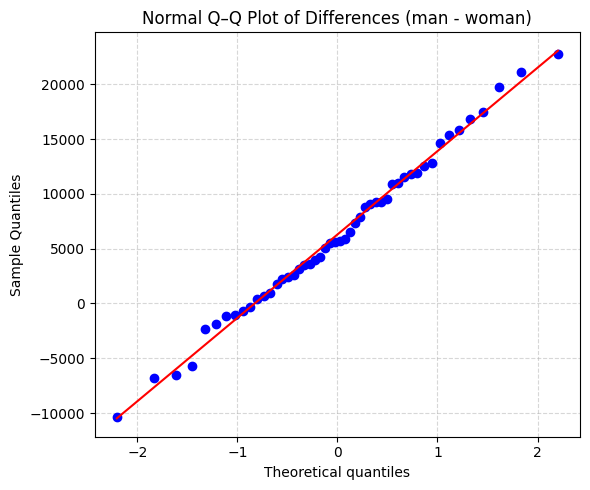

{'t-statistic': 5.9849,
 'degrees of freedom': 49,
 'p-value': '2.4690e-07',
 'mean of differences': 6294.625,
 '95% confidence interval': (4181.06, 8408.19)}

In [42]:
# Paired differences
d = man - woman

# Paired t-test
t_stat, p_val = ttest_rel(man, woman)

# One-sample t-test on differences is mathematically the same
# Confidence Interval
mean_d = d.mean()
se_d = d.std(ddof=1) / np.sqrt(len(d))
df_val = len(d) - 1
ci_low = mean_d - t.ppf(0.975, df_val) * se_d
ci_high = mean_d + t.ppf(0.975, df_val) * se_d

# Q-Q Plot
plt.figure(figsize=(6, 5))
probplot(d, dist="norm", plot=plt)
plt.title("Normal Q–Q Plot of Differences (man - woman)")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# Final output
{
    "t-statistic": round(t_stat, 4),
    "degrees of freedom": df_val,
    "p-value": format(p_val, ".4e"),
    "mean of differences": round(mean_d, 3),
    "95% confidence interval": (round(ci_low, 2), round(ci_high, 2))
}

In [38]:
# One-sample t-test on differences against mean = 0
t_stat_1samp, p_val_1samp = ttest_1samp(d, popmean=0)

# Confidence interval
mean_d = d.mean()
se_d = d.std(ddof=1) / np.sqrt(len(d))
ci_low_1samp = mean_d - t.ppf(0.975, df_val) * se_d
ci_high_1samp = mean_d + t.ppf(0.975, df_val) * se_d

# Output results
{
    "One-sample t-statistic": round(t_stat_1samp, 4),
    "Degrees of freedom": df_val,
    "p-value": format(p_val_1samp, ".4e"),
    "Mean of d": round(mean_d, 3),
    "95% confidence interval": (round(ci_low_1samp, 2), round(ci_high_1samp, 2))
}

{'One-sample t-statistic': 5.9849,
 'Degrees of freedom': 49,
 'p-value': '2.4690e-07',
 'Mean of d': 6294.625,
 '95% confidence interval': (4181.06, 8408.19)}

# Example – fraud fractions Utrecht and Den Haag

In [56]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest

# Load and clean dataset
df = pd.read_csv("toeslagfraude.txt", delim_whitespace=True)
df.columns = df.columns.str.replace('"', '')
df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
df["fraude"] = df["fraude"].astype(int)
df["friesland"] = df["friesland"].astype(int)

# First test: small sample
counts1 = [20, 19]
nobs1 = [1000, 1500]
stat1, pval1 = proportions_ztest(count=counts1, nobs=nobs1)

# Second test: scaled up (same proportions, larger n)
counts2 = [200, 190]
nobs2 = [10000, 15000]
stat2, pval2 = proportions_ztest(count=counts2, nobs=nobs2)

# Output both results
{
    "Small sample test p-value": round(pval1, 4),
    "Large sample test p-value": format(pval2, ".2e")
}


{'Small sample test p-value': 0.1472, 'Large sample test p-value': '4.57e-06'}

# Example – parcels

In [63]:
# Load data
df = pd.read_csv("parcels.txt", delim_whitespace=True)
df.columns = df.columns.str.replace('"', '')  # clean column names
df = df.astype(int)

# Display the first 6 and last 6 rows of the dataframe
df_head = df.head(6)
df_tail = df.tail(6)

df_head, df_tail

(   monday  saturday
 0  184148    187920
 1  186547    169072
 2  268517    250565
 3  189160    188457
 4  186355    195368
 5  338145    348423,
     monday  saturday
 46  140752    116722
 47  379460    380978
 48  265023    268767
 49  186663    168097
 50  178632    163420
 51  144768    145988)

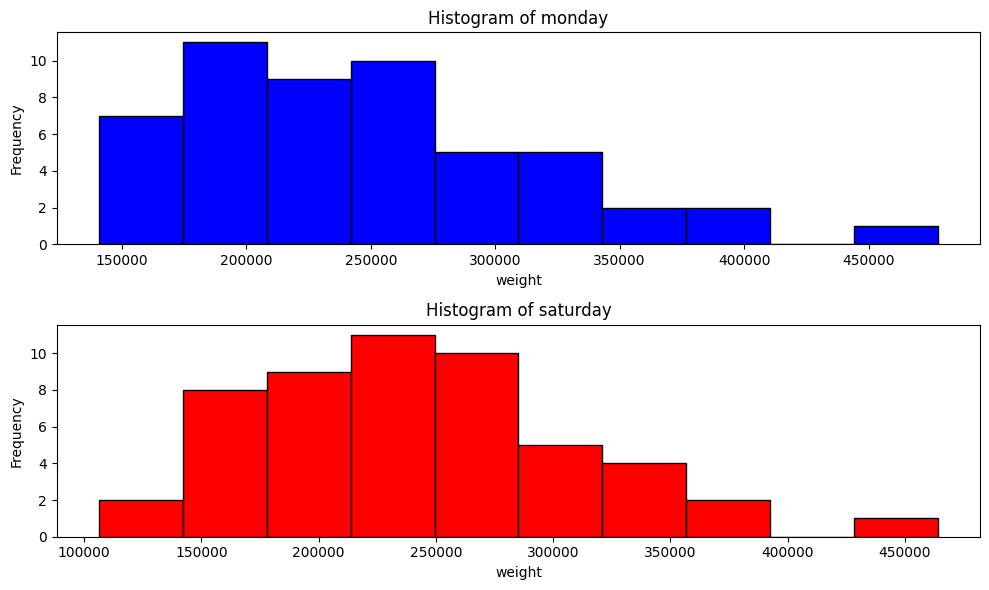

In [65]:
# Plot histograms similar to R layout
plt.figure(figsize=(10, 6))

# Histogram of Monday
plt.subplot(2, 1, 1)
plt.hist(df["monday"], bins=10, color='blue', edgecolor='black')
plt.title("Histogram of monday")
plt.ylabel("Frequency")
plt.xlabel("weight")

# Histogram of Saturday
plt.subplot(2, 1, 2)
plt.hist(df["saturday"], bins=10, color='red', edgecolor='black')
plt.title("Histogram of saturday")
plt.ylabel("Frequency")
plt.xlabel("weight")

plt.tight_layout()
plt.show()

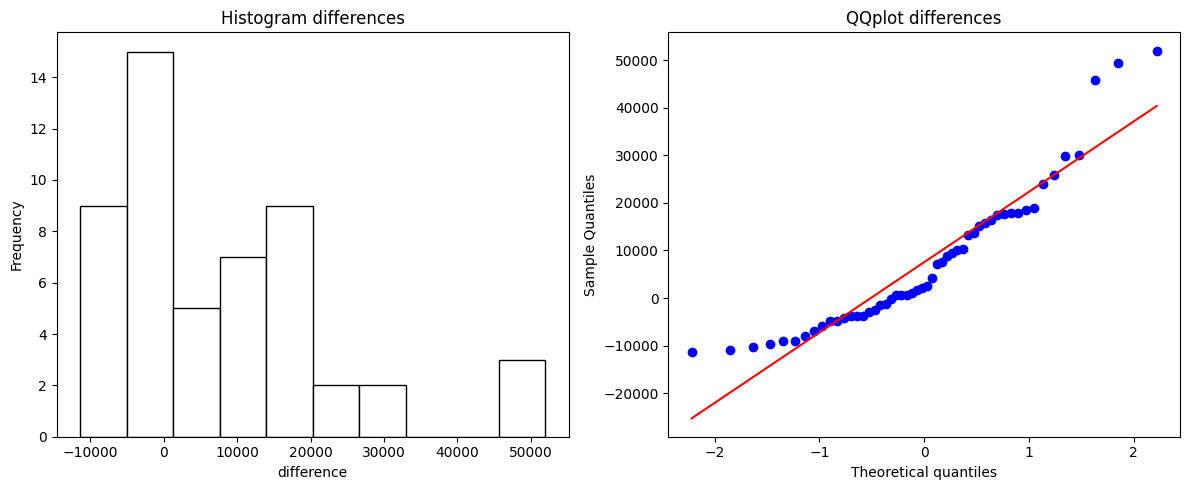

{'Shapiro-Wilk p-value': 0.0002821,
 'Sign test: number of monday < saturday': 20,
 'Total pairs': 52,
 'Sign test p-value (binomial)': 0.1263}

In [67]:
from scipy.stats import shapiro, probplot, binomtest

# Compute differences
d = df["monday"] - df["saturday"]

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = shapiro(d)

# Count number of negative differences for sign test
t = (d < 0).sum()
n = len(d)

# Sign test using binomial test (H0: median difference = 0)
sign_test_result = binomtest(t, n=n, p=0.5, alternative='two-sided')

# Plot histogram and Q-Q plot of differences
plt.figure(figsize=(12, 5))

# Histogram of differences
plt.subplot(1, 2, 1)
plt.hist(d, bins=10, color='white', edgecolor='black')
plt.title("Histogram differences")
plt.xlabel("difference")
plt.ylabel("Frequency")

# Q-Q plot of differences
plt.subplot(1, 2, 2)
probplot(d, dist="norm", plot=plt)
plt.title("QQplot differences")
plt.ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Output statistical test results
{
    "Shapiro-Wilk p-value": round(shapiro_p, 7),
    "Sign test: number of monday < saturday": t,
    "Total pairs": n,
    "Sign test p-value (binomial)": round(sign_test_result.pvalue, 4)
}


# Example – grades

In [72]:
from scipy.stats import wilcoxon

# Define the grades dataset
grades = [3.7, 5.2, 6.9, 7.2, 6.4, 9.3, 4.3, 8.4, 6.5, 8.1, 7.3, 6.1, 5.8]
sorted_grades = sorted(grades)

sorted_grades

[3.7, 4.3, 5.2, 5.8, 6.1, 6.4, 6.5, 6.9, 7.2, 7.3, 8.1, 8.4, 9.3]

In [74]:
# Wilcoxon signed-rank test against median = 6
w_stat, p_val = wilcoxon(np.array(grades) - 6)

# Output
{
    "Wilcoxon statistic (W)": int(w_stat),
    "p-value": round(p_val, 4),
    "Conclusion (alpha=0.05)": "Fail to reject H0 (symmetric around 6)" if p_val > 0.05 else "Reject H0"
}

{'Wilcoxon statistic (W)': 27,
 'p-value': 0.2163,
 'Conclusion (alpha=0.05)': 'Fail to reject H0 (symmetric around 6)'}

# Example – incomes group1 and group2

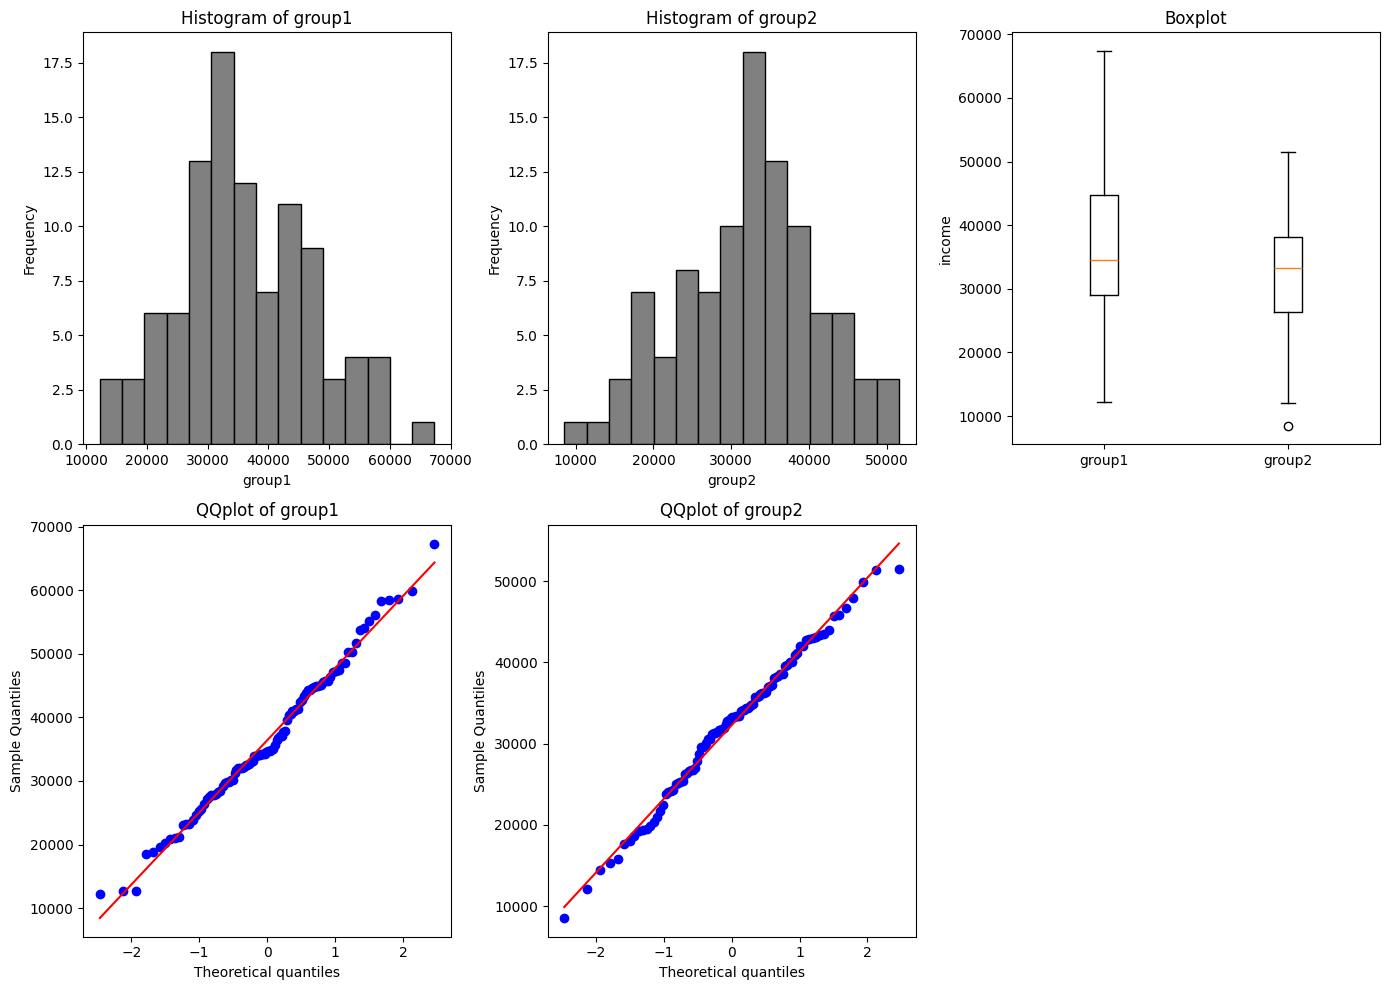

{'Mann-Whitney U (Wilcoxon rank sum)': 5995,
 'p-value': 0.015101,
 'Conclusion (alpha=0.05)': 'Reject H0: Medians differ'}

In [81]:
# Load city income data
df = pd.read_csv("cityincomes.txt", delim_whitespace=True)
df.columns = df.columns.str.replace('"', '')
df["city"] = df["city"].str.replace('"', '')
df["income"] = df["income"].astype(float)

# Extract groups for comparison (group1 and group2)
group1 = df[df["city"] == "amsterdam"]["income"]
group2 = df[df["city"] == "rotterdam"]["income"]

# Mann-Whitney U test (Wilcoxon rank-sum test equivalent in scipy)
from scipy.stats import mannwhitneyu, probplot

# Perform test with continuity correction
stat, p_value = mannwhitneyu(group1, group2, alternative="two-sided")

# Visualization
plt.figure(figsize=(14, 10))

# Histograms
plt.subplot(2, 3, 1)
plt.hist(group1, bins=15, color='gray', edgecolor='black')
plt.title("Histogram of group1")
plt.xlabel("group1")
plt.ylabel("Frequency")

plt.subplot(2, 3, 2)
plt.hist(group2, bins=15, color='gray', edgecolor='black')
plt.title("Histogram of group2")
plt.xlabel("group2")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(2, 3, 3)
plt.boxplot([group1, group2], labels=["group1", "group2"])
plt.title("Boxplot")
plt.ylabel("income")

# QQ plots
plt.subplot(2, 3, 4)
probplot(group1, dist="norm", plot=plt)
plt.title("QQplot of group1")
plt.ylabel("Sample Quantiles")

plt.subplot(2, 3, 5)
probplot(group2, dist="norm", plot=plt)
plt.title("QQplot of group2")
plt.ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()

# Output test result
{
    "Mann-Whitney U (Wilcoxon rank sum)": int(stat),
    "p-value": round(p_value, 6),
    "Conclusion (alpha=0.05)": "Reject H0: Medians differ" if p_value < 0.05 else "Fail to reject H0"
}


# $\chi^2$ distribution

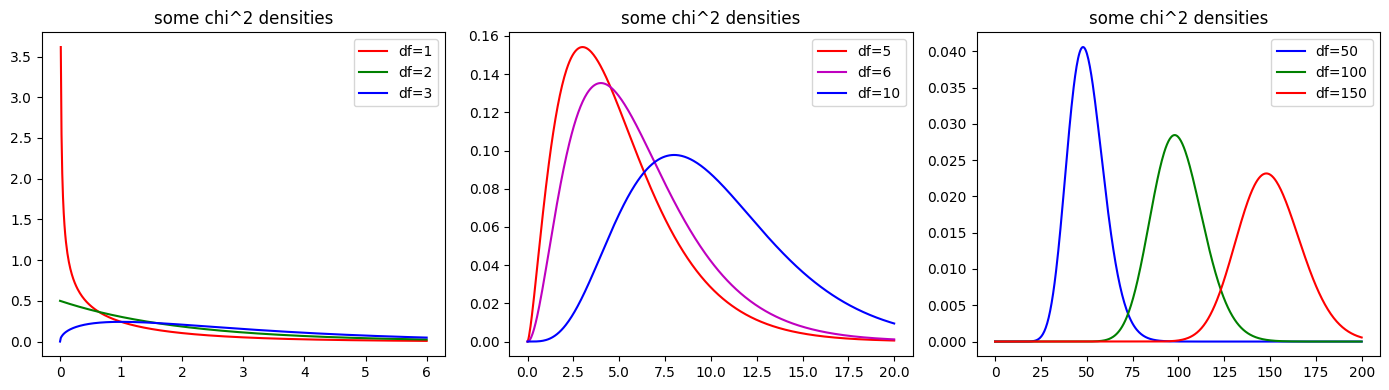

In [84]:
from scipy.stats import chi2

# Define x ranges for each subplot
x1 = np.linspace(0, 6, 500)
x2 = np.linspace(0, 20, 500)
x3 = np.linspace(0, 200, 500)

# Create figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Left plot: df = 1, 2, 3
axs[0].plot(x1, chi2.pdf(x1, df=1), 'r-', label='df=1')
axs[0].plot(x1, chi2.pdf(x1, df=2), 'g-', label='df=2')
axs[0].plot(x1, chi2.pdf(x1, df=3), 'b-', label='df=3')
axs[0].set_title("some chi^2 densities")
axs[0].legend()

# Middle plot: df = 5, 6, 10
axs[1].plot(x2, chi2.pdf(x2, df=5), 'r-', label='df=5')
axs[1].plot(x2, chi2.pdf(x2, df=6), 'm-', label='df=6')
axs[1].plot(x2, chi2.pdf(x2, df=10), 'b-', label='df=10')
axs[1].set_title("some chi^2 densities")
axs[1].legend()

# Right plot: df = 50, 100, 150
axs[2].plot(x3, chi2.pdf(x3, df=50), 'b-', label='df=50')
axs[2].plot(x3, chi2.pdf(x3, df=100), 'g-', label='df=100')
axs[2].plot(x3, chi2.pdf(x3, df=150), 'r-', label='df=150')
axs[2].set_title("some chi^2 densities")
axs[2].legend()

plt.tight_layout()
plt.show()


# $\chi^2$ test

# Example – study and gender

In [90]:
import numpy as np
from scipy.stats import chi2_contingency

# Construct the contingency table
# Rows: men, women; Columns: exact, arts
table = np.array([[23, 17],
                  [7, 13]])

# Perform Chi-squared test with Yates' continuity correction (default in scipy)
chi2_stat, p_val, dof, expected = chi2_contingency(table, correction=True)

table

array([[23, 17],
       [ 7, 13]])

In [92]:
# Output results
{
    "Chi-squared statistic": round(chi2_stat, 4),
    "Degrees of freedom": dof,
    "p-value": round(p_val, 4)
}


{'Chi-squared statistic': 1.875, 'Degrees of freedom': 1, 'p-value': 0.1709}

# Example – success rate in statistics

In [97]:
# Construct the contingency table (3 rows × 2 columns)
# Rows: 4 hours, 8 hours, 12 hours
table = np.array([
    [91, 23],
    [53, 19],
    [38, 3]
])

# Perform Pearson's chi-squared test (no Yates correction for tables > 2x2)
chi2_stat, p_val, dof, expected = chi2_contingency(table, correction=False)

# Output
{
    "Chi-squared statistic": round(chi2_stat, 4),
    "Degrees of freedom": dof,
    "p-value": round(p_val, 5)
}


{'Chi-squared statistic': 5.9963, 'Degrees of freedom': 2, 'p-value': 0.04988}

In [99]:
# Observed data
observed = np.array([
    [91, 23],
    [53, 19],
    [38, 3]
])

# Perform chi-squared test to get expected frequencies
_, _, _, expected = chi2_contingency(observed, correction=False)

# Manually compute chi-squared statistic
X2_manual = np.sum((observed - expected)**2 / expected)

# Compute p-value manually
df = (observed.shape[0] - 1) * (observed.shape[1] - 1)
p_manual = 1 - chi2.cdf(X2_manual, df)

# Output
{
    "Expected frequencies": np.round(expected, 4).tolist(),
    "Chi-squared (manual)": round(X2_manual, 6),
    "Degrees of freedom": df,
    "p-value (manual)": round(p_manual, 8)
}

{'Expected frequencies': [[91.4009, 22.5991],
  [57.7269, 14.2731],
  [32.8722, 8.1278]],
 'Chi-squared (manual)': 5.996284,
 'Degrees of freedom': 2,
 'p-value (manual)': 0.04987966}

In [101]:
# Compute raw Pearson residuals: (observed - expected) / sqrt(expected)
residuals = (observed - expected) / np.sqrt(expected)

# Round for display
rounded_residuals = np.round(residuals, 7)

# Identify cells contributing most
max_abs_resid = np.unravel_index(np.argmax(np.abs(residuals)), residuals.shape)
max_contributors = {
    "cell (row, col)": max_abs_resid,
    "residual value": residuals[max_abs_resid]
}

rounded_residuals.tolist(), max_contributors


([[-0.0419315, 0.0843276], [-0.6221353, 1.2511641], [0.8943601, -1.7986301]],
 {'cell (row, col)': (2, 1), 'residual value': -1.7986301390601374})

In [103]:
# Create a labeled DataFrame from the residuals
residual_table = pd.DataFrame(
    data=np.round(residuals, 7),
    index=["4 hours", "8 hours", "12 hours"],
    columns=["passed", "failed"]
)

residual_table

,passed,failed
4 hours,-0.041931,0.084328
8 hours,-0.622135,1.251164
12 hours,0.894360,-1.798630


### What if the condition is not fulfilled?

In [106]:
# Define the contingency table as in the R example
table = np.array([
    [7, 8, 6],
    [2, 1, 2]
])

# Perform chi-squared test
chi2_stat, p_val, dof, expected = chi2_contingency(table, correction=False)

# Check how many expected counts are < 5
below_5_count = np.sum(expected < 5)
total_cells = expected.size
below_5_percent = 100 * below_5_count / total_cells

# Output results
{
    "Chi-squared statistic": round(chi2_stat, 4),
    "Degrees of freedom": dof,
    "p-value": round(p_val, 4),
    "Expected values": np.round(expected, 2).tolist(),
    "Cells with expected < 5": below_5_count,
    "Percent of cells < 5": f"{below_5_percent:.2f}%",
    "Warning": "Chi-squared approximation may be incorrect" if below_5_percent > 20 else "OK"
}


{'Chi-squared statistic': 0.6053,
 'Degrees of freedom': 2,
 'p-value': 0.7389,
 'Expected values': [[7.27, 7.27, 6.46], [1.73, 1.73, 1.54]],
 'Cells with expected < 5': 3,
 'Percent of cells < 5': '50.00%',
 'Warning': 'Chi-squared approximation may be incorrect'}

In [110]:
# Create a labeled DataFrame for the expected values
expected_df = pd.DataFrame(
    np.round(expected, 2),
    index=["A1", "A2"],
    columns=["B1", "B2", "B3"]
)
expected_df

,B1,B2,B3
A1,7.27,7.27,6.46
A2,1.73,1.73,1.54


# Fisher’s exact test for 2x2-tables

In [113]:
import pandas as pd
from scipy.stats import fisher_exact

# Create 2x2 table for handedness by gender
table = pd.DataFrame(
    [[2780, 3281], [311, 300]],
    index=["right-handed", "left-handed"],
    columns=["men", "women"]
)

# Fisher's Exact Test
odds_ratio, p_value = fisher_exact(table)

# Output table and test results
table, round(odds_ratio, 4), round(p_value, 6)


(               men  women
 right-handed  2780   3281
 left-handed    311    300,
 0.8173,
 0.019182)

In [117]:
# Re-import necessary packages after kernel reset
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2

table = pd.DataFrame(
    [[2780, 3281], [311, 300]],
    index=["right-handed", "left-handed"],
    columns=["men", "women"]
)

# Convert to NumPy array
table_np = table.to_numpy()

# Fisher's exact test (with CI)
fisher_result = Table2x2(table_np)
odds_ratio = fisher_result.oddsratio
ci_low, ci_high = fisher_result.oddsratio_confint()
_, fisher_pval = fisher_exact(table_np)

# Chi-squared test with Yates correction
chi2_stat, chi2_pval, dof, _ = chi2_contingency(table_np, correction=True)

# Summarize results in one table
summary_df = pd.DataFrame({
    "Test": ["Fisher’s Exact", "Chi-squared (Yates)"],
    "Odds Ratio": [round(odds_ratio, 7), None],
    "95% CI": [f"[{round(ci_low, 7)}, {round(ci_high, 7)}]", None],
    "Chi-squared": [None, round(chi2_stat, 4)],
    "df": [None, dof],
    "p-value": [round(fisher_pval, 5), round(chi2_pval, 5)]
})

summary_df


,Test,Odds Ratio,95% CI,Chi-squared,df,p-value
0,Fisher’s Exact,0.817334,"[0.692, 0.9653677]",NaN,NaN,0.01918
1,Chi-squared (Yates),NaN,None,5.4542,1.0,0.01952


In [119]:
table

,men,women
right-handed,2780,3281
left-handed,311,300
